### DATASET PREPPROCESSING
To preprocess an input data from a sensor, we have to watch out for several nuances that happens for a time series data.The sensor microphones collects the Sound wave and converts them into electrical signal in the form of voltage distortion which will be, in the case of a Microcontroller sampled at 16KHZ (i.e 16,000 data points per second). This data is required to be fed into our neural network as fast as possible. The preprocesing of the input will be looking at how our data input can be differentiated from each other. We first convert from a time domain into a frequecny domain where the signals can then be transformed into a human differentiable images called the spectrogram. Neural Networks itself mimics how the human brain works to solve a problem. To mimic this on the neural netwrok architecture, we have to be fed with an human like input for proper differentiation of the audio samples
### But first,  Let us merge our dataset to the Tensorlow's speech command DataSet

In [2]:
%tensorflow_version 1.x
!pip install ffmpeg-python > 0
!pip install tensorflow-io > 0
!pip install python_speech_features > 0
#!pip install tensorflow-io-nightly >0
!pip install librosa >0
!pip install ffmpeg-python &> 0
!apt-get update && apt-get -qq install xxd
print("Package Installed")

TensorFlow 1.x selected.
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [49.8 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [3]:
# Download Speech Command Datase
!wget https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz 
DATASET_DIR =  'dataset/'
!mkdir dataset
!tar -xf speech_commands_v0.02.tar.gz -C 'dataset'
!rm -r -f speech_commands_v0.02.tar.gz

--2021-03-30 01:14:21--  https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G  87.4MB/s    in 29s     

2021-03-30 01:14:50 (79.0 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [4]:
# Comment This out to Upload OGG file is you are running from Google Collabs

# from google.colab import files
# uploaded = files.upload()

In [ ]:
# convert the ogg files( Recorded for Words "ON", "LIGHT", "OFF", "FAN", "HEATER") to wavs
!mkdir wavs
!find *.ogg -print0 | xargs -0 basename -s .ogg | xargs -I {} ffmpeg -i {}.ogg -ar 16000 wavs/{}.wav
!rm -r -f *.ogg

# then we use pete's tool to only extract 1 second clips from them for use with the Speech Command Pipeline
!mkdir trimmed_wavs
!git clone https://github.com/petewarden/extract_loudest_section.git
!make -C extract_loudest_section/
!/tmp/extract_loudest_section/gen/bin/extract_loudest_section 'wavs/*.wav' trimmed_wavs/
!rm -r -f /wavs

In [ ]:
# Store them in the appropriate folders
data_index = {}
os.chdir('trimmed_wavs')
search_path = os.path.join('*.wav')
for wav_path in glob.glob(search_path):
    matches = re.search('([^/_]+)_([^/_]+)\.wav', wav_path)
    if not matches:
        raise Exception('File name not in a recognized form:"%s"' % wav_path)
    word = matches.group(1).lower()
    instance = matches.group(2).lower()
    if not word in data_index:
      data_index[word] = {}
    if instance in data_index[word]:
        raise Exception('Audio instance already seen:"%s"' % wav_path)
    data_index[word][instance] = wav_path

output_dir = os.path.join('..', 'dataset')
try:
    os.mkdir(output_dir)
except:
    pass
for word in data_index:
  word_dir = os.path.join(output_dir, word)
  try:
      os.mkdir(word_dir)
      print('Created dir: ' + word_dir)
  except:
      print('Storing in existing dir: ' + word_dir)
  for instance in data_index[word]:
    wav_path = data_index[word][instance]
    output_path = os.path.join(word_dir, instance + '.wav')
    shutil.copyfile(wav_path, output_path)
os.chdir('..')
!rm -r -f trimmed_wavs

In [3]:
import os
import pathlib
from python_speech_features import mfcc

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio
import librosa
import ffmpeg
import pickle
import librosa.display
from tensorflow.python.ops import gen_audio_ops as audio_ops

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [17]:
!rm -r dataset

rm: cannot remove 'dataset': No such file or directory


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/dataset.zip -d /content>0

In [6]:
data_dir = pathlib.Path('dataset')

In [7]:
""" Read Samples directory into an Array Excluding irrelivant directories
"""

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'validation_list.txt']
commands = commands[commands != "_background_noise_"]
commands = commands[commands != 'LICENSE']
commands = commands[commands != '.DS_Store']
commands = commands[commands != 'README.md']
commands = commands[commands != 'testing_list.txt']

print('Commands:', commands)
print(len(commands))


Commands: ['right' 'off' 'eight' 'happy' 'one' 'six' 'fan' 'four' 'learn' 'visual'
 'on' 'cat' 'wow' 'bed' 'three' 'nine' 'yes' 'up' 'stop' 'bird' 'left'
 'sheila' 'silence' 'light' 'seven' 'forward' 'house' 'five' 'heater' 'no'
 'go' 'two' 'zero' 'follow' 'tree' 'backward' 'dog' 'down' 'marvin']
39


In [143]:
files = tf.io.gfile.glob(str(data_dir) + '/*/*')
files = tf.random.shuffle(files)
num_samples = len(files)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      )
print('Example file tensor:', files[0])


Number of total examples: 107365
Number of examples per label:
Example file tensor: tf.Tensor(b'dataset/up/2c7c33e8_nohash_0.wav', shape=(), dtype=string)


In [144]:
for i in range(len(commands)):
    print('Number of samples for '+str(commands[i])+ " label:", 
          len(tf.io.gfile.listdir(str(data_dir/commands[i])))
          
      )
    

Number of samples for right label: 3778
Number of samples for off label: 3958
Number of samples for eight label: 3787
Number of samples for happy label: 2054
Number of samples for one label: 3890
Number of samples for six label: 3860
Number of samples for fan label: 332
Number of samples for four label: 3728
Number of samples for learn label: 1575
Number of samples for visual label: 1592
Number of samples for on label: 4071
Number of samples for cat label: 2031
Number of samples for wow label: 2123
Number of samples for bed label: 2014
Number of samples for three label: 3727
Number of samples for nine label: 3934
Number of samples for yes label: 4044
Number of samples for up label: 3723
Number of samples for stop label: 3872
Number of samples for bird label: 2064
Number of samples for left label: 3801
Number of samples for sheila label: 2022
Number of samples for silence label: 75
Number of samples for light label: 351
Number of samples for seven label: 3998
Number of samples for forwa

In [132]:
len(files)

107365

# Split Dataset into Training, Validation and Testing

In [145]:
no_of_samples = len(files)

train_percent = int(0.7*no_of_samples)
val_percent = int((no_of_samples*0.3)*0.7)
test_percent = int((no_of_samples*0.3)*0.3)


train_files = files[:train_percent]
val_files = files[train_percent: train_percent+val_percent]
test_files = files[(train_percent+val_percent):]


print(" Number of Samples for training: ", len(train_files))
print(" Number of Samples for val: ", len(val_files))
print(" Number of Samples for testing: ", len(test_files))

 Number of Samples for training:  75155
 Number of Samples for val:  22546
 Number of Samples for testing:  9664


In [146]:
def decode_audio(audio_binary):
    """A WAV file includes time series data at a fixed sampling rate of one sample per second. 
    Every sample reflects the amplitude of the audio signal at that particular time.
    This Method uses the tf.audio.decode_wav to decode Audio into a binary encoded Tensor
        Returns Tensor Audio and the Sample Rate
    """
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    """ Return the Label on each file path using the Parent's Directory Name
    """
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]


def get_waveform_and_label(file_path):
    """ Return the waveform and of each audio samples 
    """
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

# Let us Decode all the Audio Samples in the Dataset and save them in a tensor

In [147]:
"""
Map all audio Samples in the training files into a dataset, Uses the autoTune Efficiency to manage data Parallelism
Adapted from https://www.tensorflow.org/guide/data_performance
"""

files_in_tensor = tf.data.Dataset.from_tensor_slices(train_files)
waveforms = files_in_tensor.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)

# Plot Audio Wavforms(.wav) in Time domain Signal

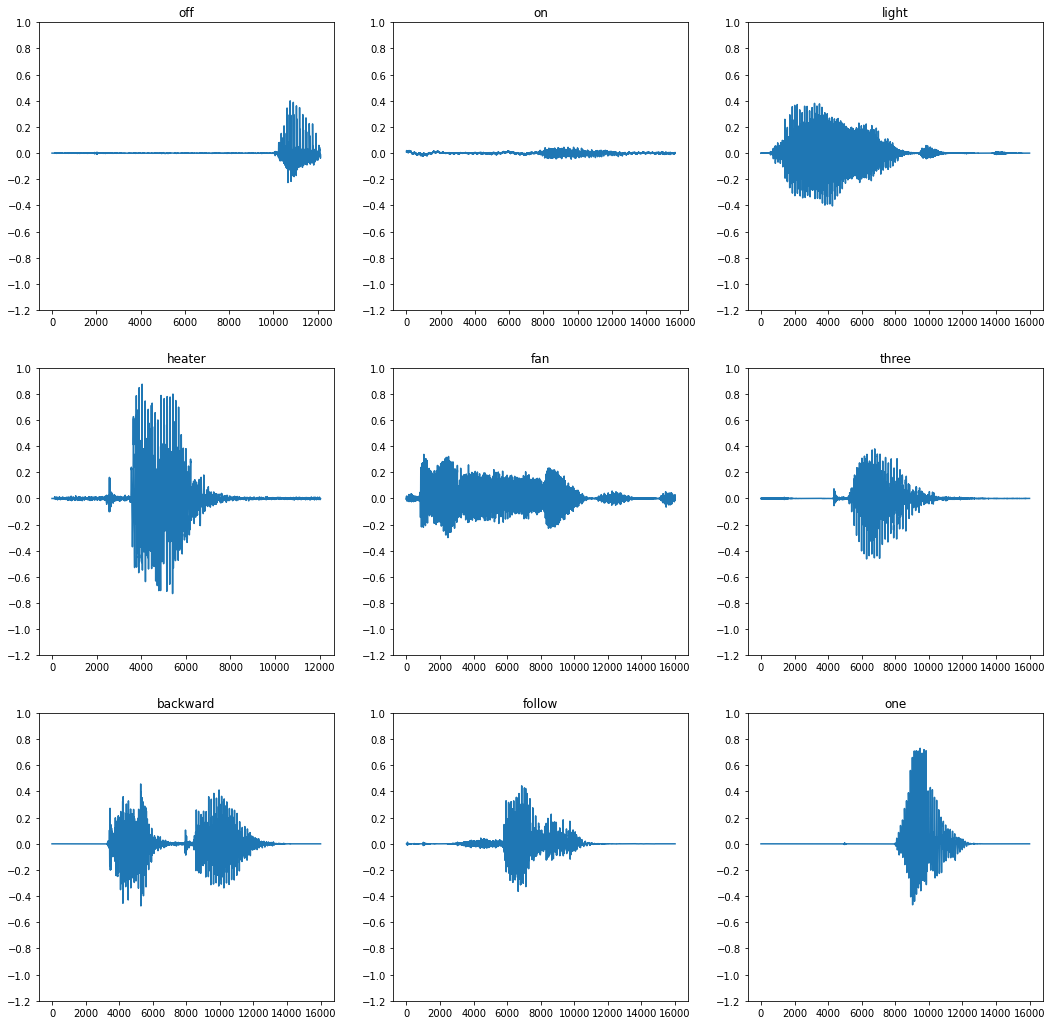

In [148]:

rows = 3
cols = 3
n = no_of_samples
data = ["on", "off", "heater", "light", "fan"]
j = 0
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
for i, (audio, label) in enumerate(waveforms.take(n)):
    if label in data or j > 4:
        if label in data:
            data.remove(label)
        r = j // cols
        c = j % cols
        ax = axes[r][c]
        ax.plot(audio.numpy())
        ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
        label = label.numpy().decode('utf-8')
        ax.set_title(label)
        j+=1
        if j==rows*cols:
            break

plt.show()


In [149]:
data = ["on", "off", "heater", "light", "fan"]
i = 0
for waveform, label in waveforms.take(5000):
    label = label.numpy().decode('utf-8')
    if label in data:
        i+=1
        data.remove(label)
        print('Label:', label)
        print('Waveform shape:', waveform.shape)
        print('Audio playback')
        display.display(display.Audio(waveform, rate=16000))
        if i==5:
            break

    




Label: off
Waveform shape: (12136,)
Audio playback


Label: on
Waveform shape: (15702,)
Audio playback


Label: light
Waveform shape: (16000,)
Audio playback


Label: heater
Waveform shape: (12041,)
Audio playback


Label: fan
Waveform shape: (16000,)
Audio playback


# To help us understand how this is converted into a Frequency domain, we convert few of the data signals into a Frequency domain Signal in Fourier Transform using an FFT(Fast Fourier Transform)

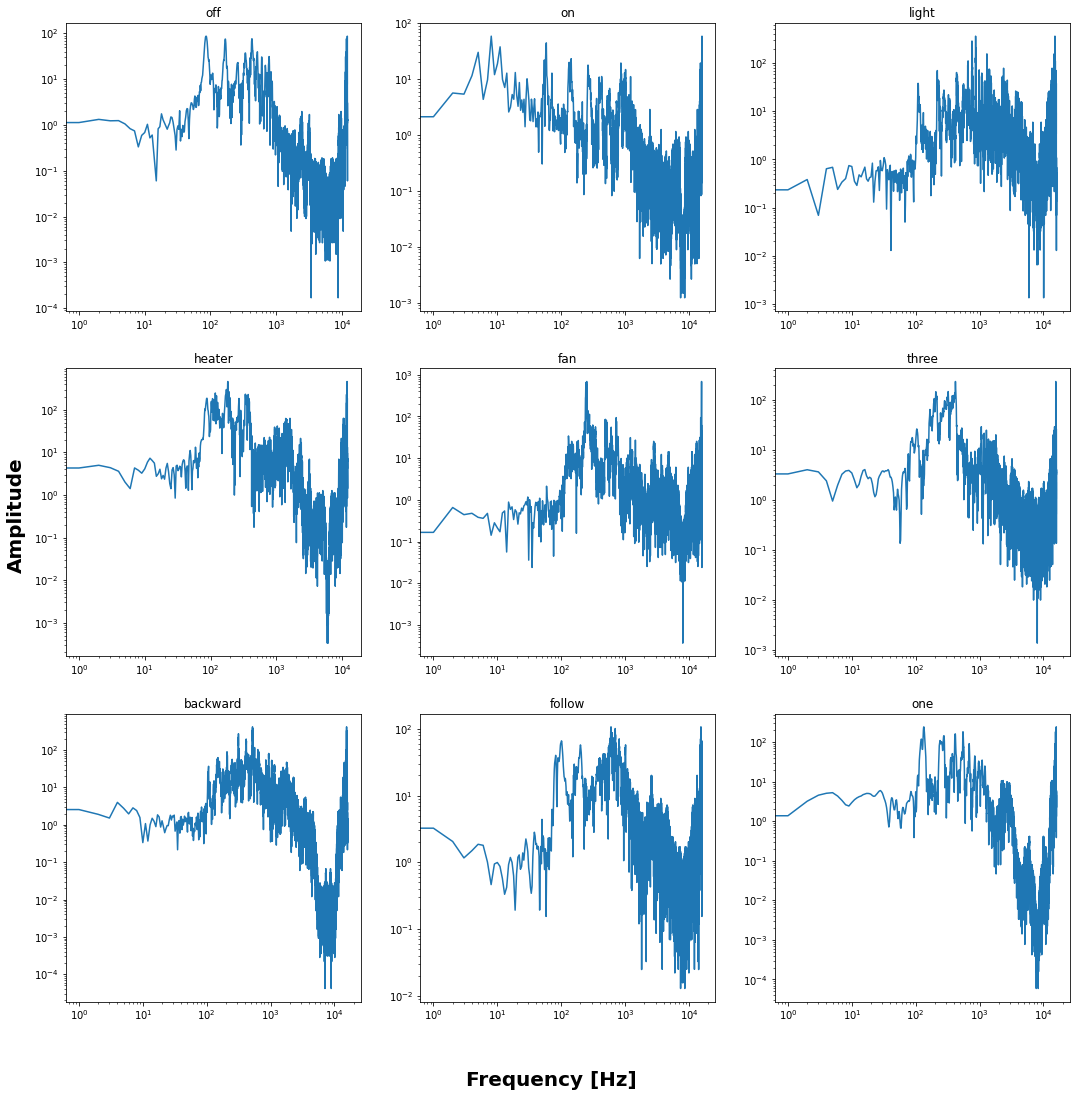

In [150]:

rows = 3
cols = 3
n = no_of_samples
data = ["on", "off", "heater", "light", "fan"]
j = 0
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
for i, (audio, label) in enumerate(waveforms.take(n)):
    if label in data or j > 4:
        # Adapted from https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform
        audio = np.abs(2*np.fft.fft(audio))
        if label in data:
            data.remove(label)
        r = j // cols
        c = j % cols
        ax = axes[r][c]
        ax.plot(audio)
        ax.set_xscale('log')
        ax.set_yscale('log')
        label = label.numpy().decode('utf-8')
        ax.set_title(label)
        j+=1
        if j==rows*cols:
            break
        
fig.text(0.5, 0.06, 'Frequency [Hz]', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Amplitude', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');
plt.show()



# Now Let us Visualize in a Spectogram

In [151]:
def get_spectrogram(waveform):
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length/1.0, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)

    
    #spectrogram = tfio.experimental.audio.spectrogram(waveform/1.0, nfft=2048, 
      #                                                         window=len(waveform), stride=128)

    #spectrogram = tf.abs(spectrogram)

    return spectrogram

In [152]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


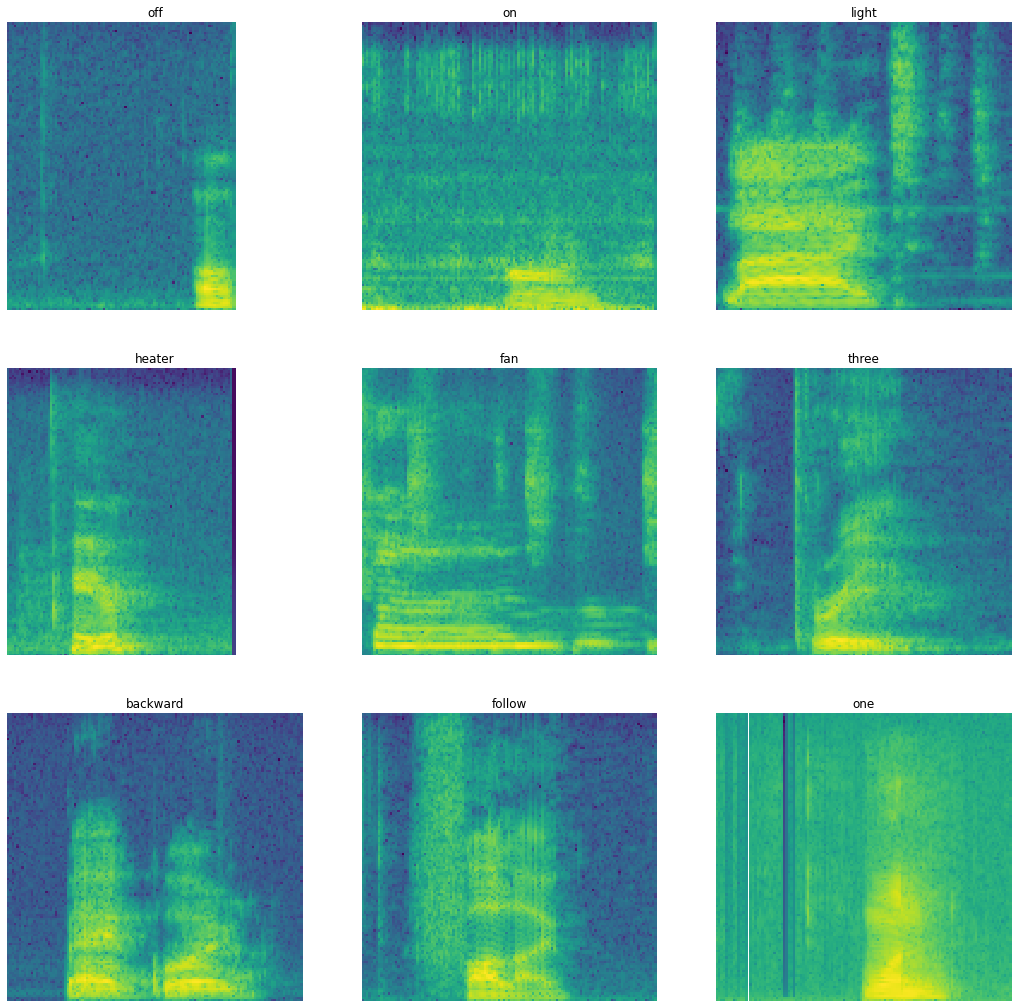

In [153]:

rows = 3
cols = 3
n = no_of_samples
data = ["on", "off", "heater", "light", "fan"]
j = 0
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
for i, (audio, label) in enumerate(waveforms.take(n)):
    if label in data or j > 4:
        label = label.numpy().decode('utf-8')
        if label in data:
            data.remove(label)
        r = j // cols
        c = j % cols
        ax = axes[r][c]
        plot_spectrogram(np.squeeze(get_spectrogram(audio)), ax)
        ax.set_title(label)
        ax.axis('off')

       
        j+=1
        if j==rows*cols:
            break
        
plt.show()

# As we may have noticed, This is even more complicated to differentiate. We can take it one step further using a Human Differentiable Spectrogram called the MEL filter Banks provided by Librosa

In [154]:
# Convert to MFCC using the Mel Scale
# adapted from: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
def get_mfcc(waveform):
    # mfcc = librosa.feature.melspectrogram(
    #    np.float32(waveform), sr=16000, n_fft=2048, n_mels=128)
    spectrogram = get_spectrogram(np.float32(waveform))
    mfcc = tfio.experimental.audio.melscale(
        input=spectrogram, rate=16000, mels=128, fmin=22.0, fmax=8000, name=None)

    return mfcc

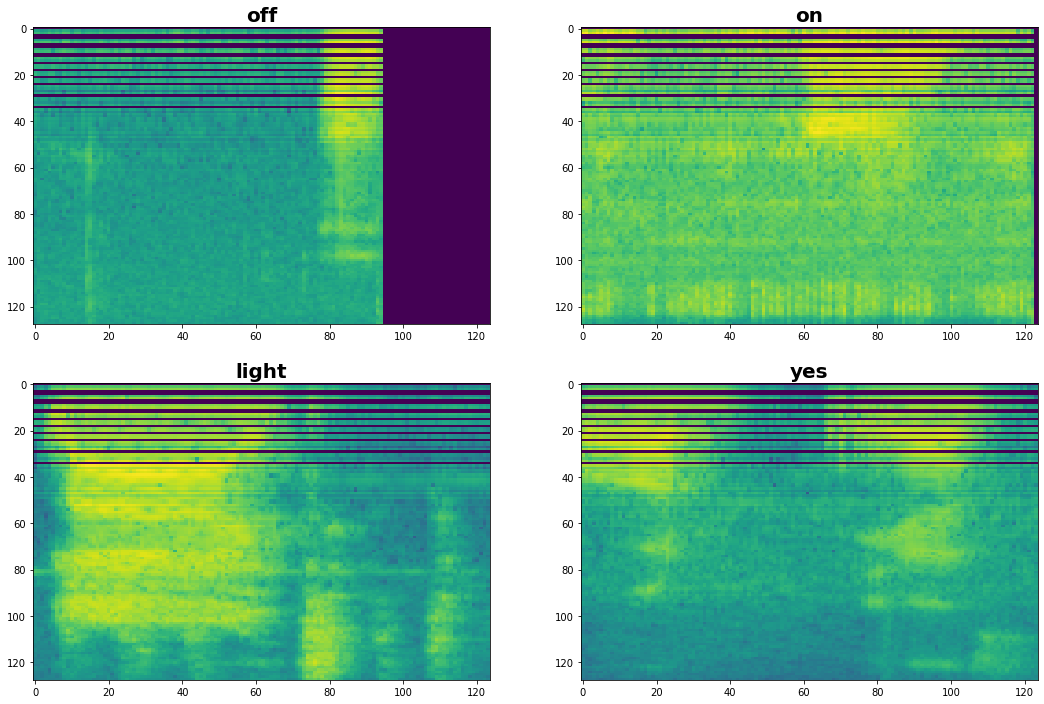

In [155]:
rows = 2
cols = 2
n = no_of_samples
data = ["on", "off", "heater", "light", "yes"]
j = 0
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
for i, (audio, label) in enumerate(waveforms.take(n)):
    if label in data or j > 4:
        label = label.numpy().decode('utf-8')
        if label in data:
            data.remove(label)
        r = j // cols
        c = j % cols
        ax = axes[r][c]
        audio = librosa.power_to_db(get_mfcc(audio), ref=np.max)
        ax.imshow(np.swapaxes(audio, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
        ax.set_title(label, {'fontsize':20, 'fontweight':'bold'})
        ax.set_ylim(ax.get_ylim()[::-1])
       
        j+=1
        if j==rows*cols:
            break
        
plt.show()

In [156]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [157]:
spectrograms = waveforms.map(
    get_spectrogram_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)
AUTOTUNE= tf.data.AUTOTUNE


In [158]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [161]:

train_ds = spectrograms
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
